In [1]:
import sys
print(sys.version)

import tensorflow as tf
print(tf.__version__)

import numpy as np
np.set_printoptions(threshold=np.inf)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
2.12.0


x.shape:  (60000, 28, 28) y.shape:  (60000,)
x_test.shape:  (10000, 28, 28) y_test.shape:  (10000,)
y[:5]:  [9 0 0 3 0]


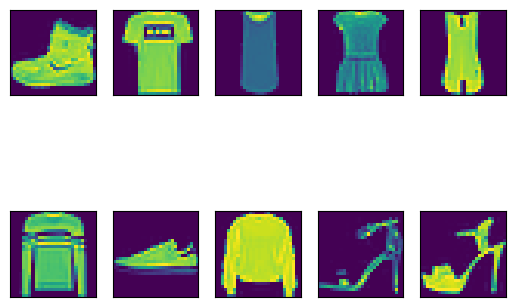

In [2]:
"""
1. 数据导入
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, Sequential, layers, optimizers, metrics
 
#（1）获取数据
(x_com, y_com), (x_test, y_test) = datasets.fashion_mnist.load_data()
 
# 查看数据集合
print('x.shape: ',x_com.shape,'y.shape: ',y_com.shape)  # x.shape:  (60000, 28, 28) y.shape:  (60000,)
print('x_test.shape: ',x_test.shape,'y_test.shape: ',y_test.shape)  # x_test.shape:  (10000, 28, 28) y_test.shape:  (10000,)
print('y[:5]: ',y_com[:5])  # y[:5]:  [9 0 0 3 0]
 
# 绘制图像
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_com[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
"""
2. 网络构造
堆叠一个6层的网络，前两个连接层设置layers.Dropout()，在神经网络训练的过程中，在指定Dropout的层中，每个神经元都有20%概率被杀死，被杀的神经元不参与正反向传播，
权重参数保持不变。每一次迭代都是选择一部分的神经元参与训练。设置dropout之间要注意训练部分的策略和验证部分的策略不一样，
需要分别指定。训练部分 network(x, training=True)，验证部分 network(x, training=False)
"""
#（2）构造网络结构
# ==1== 全连接层，6层全连接层
# [b,784]=>[b,512]=>[b,256]=>[b,128]=>[b,64]=>[b,32]=>[b,10]
network = Sequential()
network.add(layers.Dense(512, activation='relu'))  # 堆叠网络层
network.add(layers.Dropout(0.2))  # 每次前向传播每条连接都有0.2的几率被断开，训练时需要指定参数network(x, training=True)
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(10))  # logits层
# ==2== 设置输入维度
network.build(input_shape=[None, 28*28])
# ==3== 查看网络结构
network.summary()
# ==4== 优化器
optimizer = optimizers.legacy.Adam(learning_rate=0.01) # 使用动态学习率，刚训练时梯度下降速度较快，逐渐减慢
# CE变量接收交叉熵损失方法
CE = tf.losses.categorical_crossentropy

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [7]:
"""
3. 划分数据集
使用tf.data.Dataset.from_tensor_slices()将测试数据组成一个数据集，使用.map()对整个数据集使用预处理函数，用于整个神经网络训练完成后的测试。
在网络循环过程中，使用K折交叉验证法对训练集数据划分，每次循环从导入的图像数据(x_com, y_com)中随机划分出训练集和验证集。

如果按固定比例划分训练集和验证集的话，会导致有一部分数据始终无法用于训练。先给每一个xy组合生成索引，使用tf.random.shuffle()打乱索引顺序，
取50k张图片用于训练10k张图片用于验证，但不改变图像和标签之间的对应关系，充分利用有限的数据。将生成的y_train和y_val分别转换成one_hot编码，
索引对应的数值转换为1，其他位置的值都变成0，便于后续计算损失。
"""
#（3）划分数据集
# 预处理函数
def processing(x,y):
    x = 2 * tf.cast(x, dtype=tf.float32)/255.0 - 1
    y = tf.cast(y, dtype=tf.int32)
    return x,y
 
# 构造测试集
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)) 
ds_test = ds_test.map(processing).batch(128)
 
# 迭代器查看数据是否正确
sample = next(iter(ds_test))
print('x_batch:', sample[0].shape, 'y_batch:', sample[1].shape)
# x_batch: (128, 28, 28)  y_batch: (128,)
 
# 网络循环
for epochs in range(20): # 循环20次
    print('-----------------------------')    
    print('epoch:',epochs)    
 
# （5）K折交叉验证，每次循环使用不同的验证集和训练集
    idx = tf.range(60000) # 训练集x一共有60k张图像，生成60k个索引
    idx = tf.random.shuffle(idx) # 每次迭代都随机打乱所有的索引    
    
    # 使用打乱的索引收集加载进来的x_com和y_com数据
    x_train, y_train = tf.gather(x_com, idx[:50000]), tf.gather(y_com, idx[:50000])  # 训练集
    x_val, y_val = tf.gather(x_com, idx[-10000:]), tf.gather(y_com, idx[-10000:]) # 验证集
    
    # 构造训练集数据集
    y_train = tf.one_hot(y_train, depth=10)  # 对y进行onehot编码，索引对应的值为1，其他为0
    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds_train = ds_train.map(processing).shuffle(10000).batch(128) # 每次迭代取128组数据，打乱数据
    
    # 构造验证集数据集
    y_val = tf.one_hot(y_val, depth=10)  # 计算验证集的损失，看是否出现过拟合现象
    ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    ds_val = ds_val.map(processing).batch(128)

    """
    4.  网络训练
    使用交叉熵计算模型预测值和真实值之间的损失，交叉熵损失函数自动将logits层的输出通过softmax函数转换到0-1之间，并且10个分类的概率和为1。
    为了防止过拟合发生，对损失函数使用L2正则化，在原来的损失函数基础上加上权重参数的平方和。L2正则化可以产生趋近0的解。
    使用tf.nn.l2_loss()对网络的所有权重参数计算二范数，设置正则化惩罚系数为0.0001，根据公式：J( \theta )= J(w,x,y)+\lambda \sum_{i=1}^{n} w_{i}^{2}
    
    正则化之后，以损失为因变量，权重和偏置为自变量计算梯度。使用学习率动态调整的方法调整网络权重偏置，
    optimizer.learning_rate = 0.01*(20-epochs)/20，刚开始训练时梯度下降较快，最快速度接近最优点，随着网络循环的次数增加，梯度下降逐渐缓慢，更较好地逼近最优点。
    """
#（6）网络训练
    # 每次迭代一个batch
    for step, (x,y) in enumerate(ds_train):
        # 将x的shape从[128,28,28]=>[128,28*28]
        x = tf.reshape(x, [-1,28*28])
        
        # 跟踪梯度
        with tf.GradientTape() as tape:
            # 网络训练，得到logits层
            logits = network(x, training=True)
            # 计算平均交叉熵损失，from_logits自动将实数转化为概率
            loss = tf.reduce_mean(CE(y, logits, from_logits=True))
         
            # 计算二范数
            w_regular = []  # 存放权重的二范数
            # 对所有的权重计算二范数， 正则化项保存为[w1,b1,w2,b2,w3,b3,...]
            for w in network.trainable_variables[::2]: # 6组权重
                w_regular.append(tf.nn.l2_loss(w))  
                
            # loss是求的整个batch的loss，也要求整个batch的w和b二范数
            loss_regular = tf.reduce_sum(w_regular)
            
            # 对损失正则化，正则化惩罚项设置为0.0001
            loss = loss + 0.0001 * loss_regular
        
            # 动态学习率调整，每次迭代都递减，刚开始准确率为0.01
            optimizer.learning_rate = 0.01*(20-epochs)/20
            
        # 梯度计算，因变量为loss，自变量为所有的权重和偏置
        grads = tape.gradient(loss, network.trainable_variables)
        # 原地更新权重和偏置
        optimizer.apply_gradients(zip(grads, network.trainable_variables))
        
        # 每200个batch打印一次结果
        if step%200 == 0:
            print('train', 'batch_loss:', loss.numpy()) # 每一个batch的平均损失

    """
    5. 网络验证
    在上面已经对验证集的目标y_val进行了onehot编码，在和预测值计算完损失值后，需要将one_hot类型转回标签类型，和预测值比较结果是否一致，来计算准确率。
    验证集最后一层的输出结果logits经过tf.nn.softmax()函数转换成相应的概率值，
    tf.argmax()找出最大概率所在的下标，即所属的分类。看真实值和预测值是否相同来统计预测对了的个数。
    """
    #（7）验证，前向传播
    total_correct = 0  # 每次迭代有多少预测对了
    total_num = 0  # 每次迭代一共有多少参与预测
    
    for step,(x,y) in enumerate(ds_val):  # 每次验证一个batch
        # x的shape由[128,28,28]变成[b,28*28]
        x = tf.reshape(x, [-1,28*28])
        # x从第一层传播到最后一层
        logits = network(x, training=False)  #得出的是实数，需转换成概率
        
        # 计算验证集交叉熵损失
        loss = tf.reduce_mean(CE(y, logits, from_logits=True))
        
        # 计算完之后，将one_hot类型转换回标签类型，进行准确度计算
        labels = [] # 存放转换后的标签
        for label in y:
            labels.append(tf.argmax(label))
        labels = tf.convert_to_tensor(labels, dtype=tf.int32) # 转变数据类型int32
                
        # 将图片属于每一层的实数结果转换为概率
        prob = tf.nn.softmax(logits, axis=1)
        # 找到概率最大值所在的索引位置，指定axis=1，转变每一张图片属于10个分类的概率
        predict = tf.argmax(prob, axis=1, output_type=tf.int32)  # 默认输出tf.int64，而y是tf.int32类型
 
        # 对比预测值和真实值是否相同，计算有几个相同的
        correct = tf.equal(labels, predict)
        correct = tf.reduce_sum(tf.cast(correct, tf.int32))  #True代表1
        
        # 记录预测对了的概率
        total_correct += int(correct)  #从tensor类型变成数值类型
        total_num += x.shape[0]
        
        # 每100个batch打印一次准确率和损失
        if step%100 == 0:
            accuracy = total_correct/total_num
            print('val', 'batch_accuracy:', accuracy)
            print('val', 'batch_loss:', loss.numpy())
            
    # 每一次循环打印一次验证结果
    accuracy = total_correct/total_num
    print('val', 'eopch_accuracy:', accuracy)
    print('-----------------------------')

"""
6. 网络测试
测试方法和验证方法基本相同，实数转概率，找下标值，统计相同个数，不过多介绍。
"""
#（8）网络完成后测试，记录的是最后一次的权重
# 前向传播
test_correct = 0
test_num = 0
 
for step, (x, y) in enumerate(ds_test):
    # 改变输入x的shape
    x = tf.reshape(x,shape=[-1, 28*28])
    # x从[128,28*28]=>[128,10]
    logits = network(x) # 得到每张图片属于10个分类的实数
    prob = tf.nn.softmax(logits, axis=1) # 将每一个张图片属于10分类的实数变成概率，且和为1
    predict = tf.argmax(prob, axis=1, output_type=tf.int32) # 找到概率最大的下标
    # 计算准确率
    correct = tf.reduce_sum(tf.cast(tf.equal(y, predict), tf.int32))  #有多少预测对了
    # 计算概率
    test_correct += int(correct)
    test_num += x.shape[0]
    
# 整个test集的准确率
accuracy = test_correct / test_num
print('test_accuracy: ', accuracy)

"""
7. 预测
这里采用测试集中的x数据来做预测，next(iter(ds_test))，设置一个迭代器，每次运行从中取出一个batch的测试数据。
同样也是将网络最后一层logits层的输出的实数，转为概率，再找概率最大的下标，得到预测结果。最后将预测的结果和真实值的前10个数比较一下，结果相同。
"""
#（9）预测，这里使用的ds_test中的特征值x来预测
sample = next(iter(ds_test))
predict = []
for step,x in enumerate(sample[0]):  #sampel[0]中保存x数据
    # 改变输入x的shape
    x = tf.reshape(x,shape=[-1, 28*28])
    # x从[128,28*28]=>[128,10]
    logits = network(x) # 得到每张图片属于10个分类的实数
    prob = tf.nn.softmax(logits, axis=1) # 将每一个张图片属于10分类的实数变成概率，且和为1
    pred = tf.argmax(prob, axis=1) # 找到概率最大的下标
    predict.append(int(pred))
    
print('预测值：', predict[:10])
print('真实值：', sample[1][:10].numpy())

2024-06-11 10:09:25.522409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:09:25.556311: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-11 10:09:25.703058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:09:25.703186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore th

x_batch: (128, 28, 28) y_batch: (128,)
-----------------------------
epoch: 0
train batch_loss: 2.412197
train batch_loss: 0.8281379


2024-06-11 10:09:42.395286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8515625
val batch_loss: 0.4494079
val eopch_accuracy: 0.8154
-----------------------------
-----------------------------
epoch: 1


2024-06-11 10:09:45.779189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:09:45.779335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.63227695
train batch_loss: 0.686405


2024-06-11 10:10:02.126272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8515625
val batch_loss: 0.44661736
val eopch_accuracy: 0.8346
-----------------------------
-----------------------------
epoch: 2


2024-06-11 10:10:05.447442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:10:05.447588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.54756314
train batch_loss: 0.45996347


2024-06-11 10:10:21.191052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8515625
val batch_loss: 0.4047435
val eopch_accuracy: 0.8402
-----------------------------
-----------------------------
epoch: 3


2024-06-11 10:10:24.040247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:10:24.040377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.71141464
train batch_loss: 0.5640285


2024-06-11 10:10:38.677191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8671875
val batch_loss: 0.331887
val eopch_accuracy: 0.851
-----------------------------
-----------------------------
epoch: 4


2024-06-11 10:10:40.164659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:10:40.164792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.57234645
train batch_loss: 0.58574486


2024-06-11 10:10:44.965014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8515625
val batch_loss: 0.42018187
val eopch_accuracy: 0.8553
-----------------------------
-----------------------------
epoch: 5
train batch_loss: 0.64969987


2024-06-11 10:10:46.196271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:10:46.196392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.4977607


2024-06-11 10:10:50.858974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8515625
val batch_loss: 0.49494812
val eopch_accuracy: 0.8432
-----------------------------
-----------------------------
epoch: 6
train batch_loss: 0.5265297


2024-06-11 10:10:52.056995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:10:52.057116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.71722484


2024-06-11 10:10:56.628963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.875
val batch_loss: 0.3624015
val eopch_accuracy: 0.8559
-----------------------------
-----------------------------
epoch: 7
train batch_loss: 0.6550229


2024-06-11 10:10:57.843149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:10:57.843272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.56779516


2024-06-11 10:11:02.618083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8125
val batch_loss: 0.4653535
val eopch_accuracy: 0.85
-----------------------------
-----------------------------
epoch: 8
train batch_loss: 0.6094689


2024-06-11 10:11:03.818253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:11:03.818376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.5224384


2024-06-11 10:11:08.553632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.84375
val batch_loss: 0.43813306
val eopch_accuracy: 0.8507
-----------------------------
-----------------------------
epoch: 9
train batch_loss: 0.59579635


2024-06-11 10:11:09.764676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:11:09.764815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.67074794


2024-06-11 10:11:14.298158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.875
val batch_loss: 0.34418297
val eopch_accuracy: 0.8655
-----------------------------
-----------------------------
epoch: 10
train batch_loss: 0.38305622


2024-06-11 10:11:15.506432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:11:15.506550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.51060474


2024-06-11 10:11:20.215902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.890625
val batch_loss: 0.40174913
val eopch_accuracy: 0.87
-----------------------------
-----------------------------
epoch: 11
train batch_loss: 0.52454746


2024-06-11 10:11:21.428612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:11:21.428735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.36415792


2024-06-11 10:11:25.918522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8515625
val batch_loss: 0.37643218
val eopch_accuracy: 0.8675
-----------------------------
-----------------------------
epoch: 12
train batch_loss: 0.5307927


2024-06-11 10:11:27.100920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:11:27.101040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.46703154


2024-06-11 10:11:31.733105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.875
val batch_loss: 0.36160895
val eopch_accuracy: 0.8785
-----------------------------
-----------------------------
epoch: 13
train batch_loss: 0.46215624


2024-06-11 10:11:32.949773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:11:32.949891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.5105709


2024-06-11 10:11:37.628921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.8828125
val batch_loss: 0.36493134
val eopch_accuracy: 0.8748
-----------------------------
-----------------------------
epoch: 14
train batch_loss: 0.5405014


2024-06-11 10:11:38.875303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:11:38.875436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.4482199


2024-06-11 10:11:43.585872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.875
val batch_loss: 0.3147704
val eopch_accuracy: 0.8821
-----------------------------
-----------------------------
epoch: 15
train batch_loss: 0.44060877


2024-06-11 10:11:44.810311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:11:44.810428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.5763073


2024-06-11 10:11:49.531335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.90625
val batch_loss: 0.2819401
val eopch_accuracy: 0.8907
-----------------------------
-----------------------------
epoch: 16
train batch_loss: 0.36458147


2024-06-11 10:11:50.750235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:11:50.750352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.3214805


2024-06-11 10:11:55.620942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.90625
val batch_loss: 0.2824887
val eopch_accuracy: 0.8879
-----------------------------
-----------------------------
epoch: 17
train batch_loss: 0.35259986


2024-06-11 10:11:56.919316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,28,28]
	 [[{{node Placeholder/_0}}]]
2024-06-11 10:11:56.919464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.38055027


2024-06-11 10:12:01.600285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.921875
val batch_loss: 0.2222344
val eopch_accuracy: 0.8937
-----------------------------
-----------------------------
epoch: 18
train batch_loss: 0.35695413


2024-06-11 10:12:02.833976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:12:02.834102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.43525696


2024-06-11 10:12:08.041520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.859375
val batch_loss: 0.3696397
val eopch_accuracy: 0.8974
-----------------------------
-----------------------------
epoch: 19
train batch_loss: 0.432602


2024-06-11 10:12:09.426528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]
2024-06-11 10:12:09.426711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,10]
	 [[{{node Placeholder/_1}}]]


train batch_loss: 0.5652883


2024-06-11 10:12:14.060302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


val batch_accuracy: 0.921875
val batch_loss: 0.2526859
val eopch_accuracy: 0.8979
-----------------------------
test_accuracy:  0.8782
预测值： [9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
真实值： [9 2 1 1 6 1 4 6 5 7]
